# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

Linux:

In [2]:
!wget https://raw.githubusercontent.com/ganesh-k13/shell/master/test_search/www.glozman.com/TextPages/Frank%20Herbert%20-%20Dune.txt -O dune.txt
!wget https://raw.githubusercontent.com/wess/iotr/master/lotr.txt -O lotr.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Windows:

In [2]:
!curl https://raw.githubusercontent.com/ganesh-k13/shell/master/test_search/www.glozman.com/TextPages/Frank%20Herbert%20-%20Dune.txt > dune.txt
!curl https://raw.githubusercontent.com/wess/iotr/master/lotr.txt > lotr.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1170k  100 1170k    0     0  2686k      0 --:--:-- --:--:-- --:--:-- 2696k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 39 3186k   39 1272k    0     0  2767k      0  0:00:01 --:--:--  0:00:01 2766k
100 3186k  100 3186k    0     0  6321k      0 --:--:-- --:--:-- --:--:-- 6321k


In [1]:
with open("dune.txt", "r", encoding="ISO-8859-1") as f:
    text1 = f.read().lower()
with open("lotr.txt", "r") as f:
    text2 = f.read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [2]:
chars1 = sorted(list(set(text1)))
chars2 = sorted(list(set(text2)))
charset = sorted(list(set(chars1 + chars2)))
print(len(chars1), len(chars2))
print(len(charset))

54 73
76


Text(0.5, 1.0, 'J.R.R. Tolkien - Lord of the Rings')

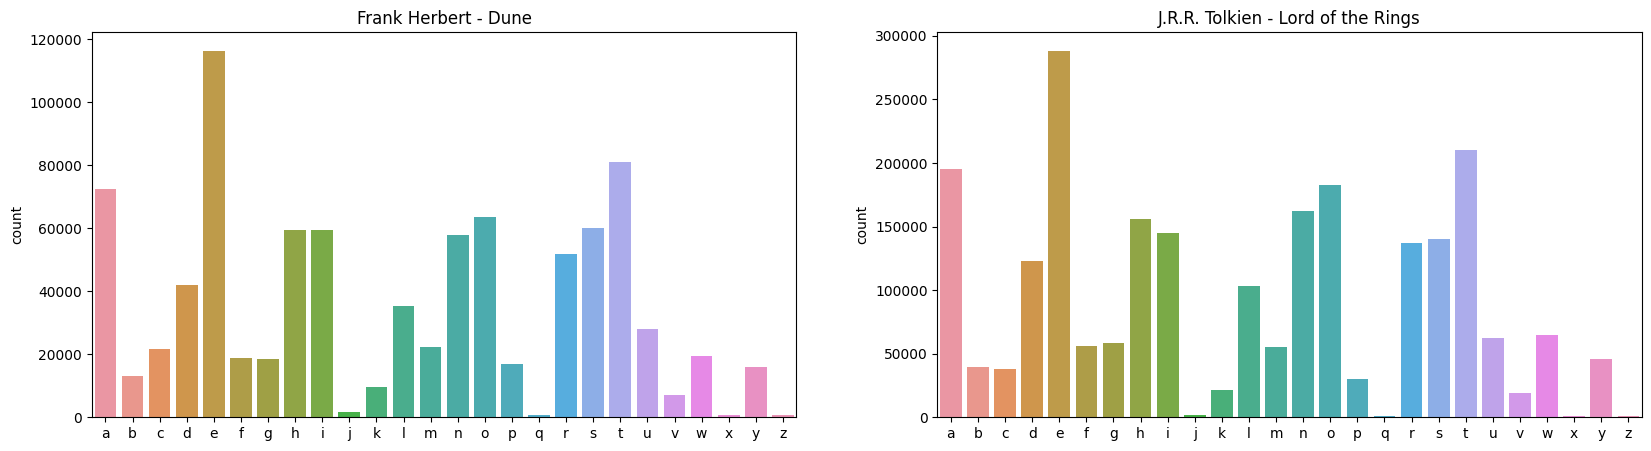

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=sorted([x for x in list(text1) if x >= 'a' and x <= 'z']), ax=axs[0]).set_title('Frank Herbert - Dune')
sns.countplot(x=sorted([x for x in list(text2) if x >= 'a' and x <= 'z']), ax=axs[1]).set_title('J.R.R. Tolkien - Lord of the Rings')


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [6]:
char_to_int = dict((c, i) for i, c in enumerate(charset))
int_to_char = dict((i, c) for i, c in enumerate(charset))

In [8]:
sequence_length = 60 # window size
alphabet_size = len(charset)
step = 10 # sliding window step

sequences1 = []
sequences2 = []

In [9]:
for i in range(0, len(text1) - sequence_length, step):
    sequences1.append(text1[i: i + sequence_length])
for i in range(0, len(text2) - sequence_length, step):
    sequences2.append(text2[i: i + sequence_length])
len(sequences1), len(sequences2)

(118990, 326212)

## Data splitting
Split the data into train, validate and test sets. Make 

In [10]:
train_size1 = int(len(sequences1) * 0.7)
test_size1 = int(len(sequences1) * 0.2)
validations_size1 = len(sequences1) - train_size1 - test_size1

train_size2 = int(len(sequences2) * 0.7)
test_size2 = int(len(sequences2) * 0.1)
validations_size2 = len(sequences2) - train_size2 - test_size2

train1 = sequences1[:train_size1]
test1 = sequences1[train_size1:train_size1 + test_size1]
validations1 = sequences1[train_size1 + test_size1:]


train2 = sequences2[:train_size2]
test2 = sequences2[train_size2:train_size2 + test_size2]
validations2 = sequences2[train_size2 + test_size2:]

X_train = np.zeros((len(train1) + len(train2), sequence_length, alphabet_size))
Y_train = np.zeros((len(train1) + len(train2)))

X_test = np.zeros((len(test1) + len(test2), sequence_length, alphabet_size))
Y_test = np.zeros((len(test1) + len(test2)))

X_valid = np.zeros((len(validations1) + len(validations2), sequence_length, alphabet_size))
Y_valid = np.zeros((len(validations1) + len(validations2)))

In [11]:
for i, sequence in enumerate(train1):
    for t, char in enumerate(sequence):
        X_train[i, t, char_to_int[char]] = 1
    Y_train[i] = 0

for i, sequence in enumerate(train2):
    for t, char in enumerate(sequence):
        X_train[i + len(train1), t, char_to_int[char]] = 1
    Y_train[i + len(train1)] = 1

for i, sequence in enumerate(test1):
    for t, char in enumerate(sequence):
        X_test[i, t, char_to_int[char]] = 1
    Y_test[i] = 0

for i, sequence in enumerate(test2):
    for t, char in enumerate(sequence):
        X_test[i + len(test1), t, char_to_int[char]] = 1
    Y_test[i + len(test1)] = 1

for i, sequence in enumerate(validations1):
    for t, char in enumerate(sequence):
        X_valid[i, t, char_to_int[char]] = 1
    Y_valid[i] = 0

for i, sequence in enumerate(validations2):
    for t, char in enumerate(sequence):
        X_valid[i + len(validations1), t, char_to_int[char]] = 1
    Y_valid[i + len(validations1)] = 1

In [12]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_valid.shape, Y_valid.shape

((311641, 60, 76),
 (311641,),
 (56419, 60, 76),
 (56419,),
 (77142, 60, 76),
 (77142,))

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [13]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, alphabet_size)))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Model training
Train the model and apply early stopping.

In [15]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

Running the model on my own computer instead of colab, since the the dataset is using about 20gb of RAM. My tensorflow installation broke and is not using my GPU, so the training is very slow.

In [16]:
model.fit(X_train, Y_train,
          batch_size=512,
          epochs=100,
          validation_data=(X_valid, Y_valid),
            callbacks=[es])

Epoch 1/100
609/609 [==============================] - 129s 208ms/step - loss: 0.2585 - accuracy: 0.8865 - val_loss: 0.1749 - val_accuracy: 0.9406
Epoch 2/100
609/609 [==============================] - 125s 205ms/step - loss: 0.1171 - accuracy: 0.9509 - val_loss: 0.1448 - val_accuracy: 0.9537
Epoch 3/100
609/609 [==============================] - 129s 212ms/step - loss: 0.0879 - accuracy: 0.9651 - val_loss: 0.1348 - val_accuracy: 0.9581
Epoch 4/100
609/609 [==============================] - 124s 203ms/step - loss: 0.0756 - accuracy: 0.9700 - val_loss: 0.1353 - val_accuracy: 0.9601
Epoch 5/100
609/609 [==============================] - 124s 204ms/step - loss: 0.0707 - accuracy: 0.9720 - val_loss: 0.1325 - val_accuracy: 0.9581
Epoch 6/100
609/609 [==============================] - 129s 212ms/step - loss: 0.0661 - accuracy: 0.9735 - val_loss: 0.1278 - val_accuracy: 0.9631
Epoch 7/100
609/609 [==============================] - 125s 205ms/step - loss: 0.0620 - accuracy: 0.9752 - val_loss: 0

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [17]:
# evaluate the model on the test set
score = model.evaluate(X_test, Y_test, verbose=0)
# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.07466085255146027
Test accuracy: 0.9752388596534729


## Confusion matrix
Calculate and display the confusion matrix.

In [24]:
from tensorflow.math import confusion_matrix as cm

1764/1764 [==============================] - 14s 8ms/step


<Axes: >

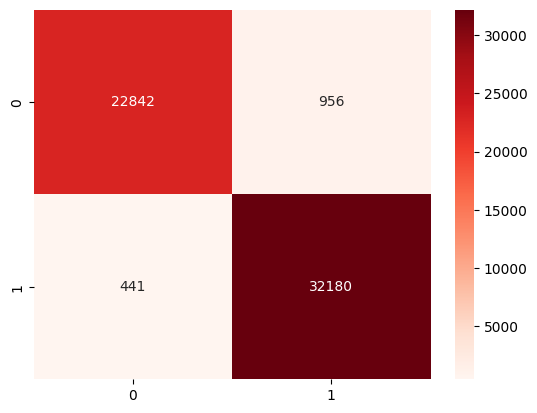

In [30]:
# create confusion matrix
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred)
confusion = cm(Y_test, Y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')


In [31]:
model.save('./model/model.h5')

#### Playing with the model, testing it on other works of the two authors

In [143]:
def predict(text):
    sequences = []
    text = text.lower()
    if len(text) < sequence_length:
        sequences.append(text)
    for i in range(0, len(text) - sequence_length, step):
        sequences.append(text[i: i + sequence_length])
    sum = 0
    for seq in sequences:
        x = np.zeros((1, sequence_length, alphabet_size))
        for t, char in enumerate(seq):
            x[0, t, char_to_int[char]] = 1
        pred = model.predict(x, verbose=0)[0][0]
        sum += pred
    avg = sum / len(sequences)
    confidence = round((avg if avg > 0.5 else 1 - avg)  * 100, 4)
    if avg > 0.5:
        print('J.R.R. Tolkien - Lord of the Rings' + ' - ' + str(confidence) + '%')
    else:
        print('Frank Herbert - Dune' + ' - ' + str(confidence) + '%')

In [144]:
predict("\"There's a way to evade the Harkonnens,\" she said.")

Frank Herbert - Dune - 99.9996%


In [145]:
predict("The spice must flow.")

Frank Herbert - Dune - 99.999%


In [146]:
predict("Now tell us where he is; for  I much desired to speak with him again.")

J.R.R. Tolkien - Lord of the Rings - 99.9945%


line from the movie, not from the book<br/>
https://www.youtube.com/watch?v=uE-1RPDqJAY

In [147]:
predict("They're taking the hobbits to Isengard!") 

J.R.R. Tolkien - Lord of the Rings - 93.2926%


To be fair, Balrogs are only mentioned 4 times in the book, and Morgoth only once, cant expect the model to learn that.

In [148]:
predict("A Balrog of Morgoth! A demon of the ancient world!") 

Frank Herbert - Dune - 88.8712%


The line from the movie:

In [149]:
predict("You shall not pass!")

Frank Herbert - Dune - 92.9056%


Line from the book:

In [150]:
predict("Go back to  the Shadow! You cannot pass.")

J.R.R. Tolkien - Lord of the Rings - 99.234%


In [151]:
predict("\'Neither  does he  use  his right name,  nor permit it  to be  spelt or \
spoken,\' said Aragorn. \'And he does  not use white. The  Orcs in the service \
of Barad-dyr use the sign of the Red Eye.\' He stood for a moment in thought. \
\'S is for Saruman, I  guess,\'  he  said at length. \'There  is evil afoot  in \
Isengard,  and the West is no longer safe. It is  as Gandalf feared: by some \
means the traitor Saruman has had news of our journey. It is likely too that \
he  knows  of  Gandalf\'s  fall.  Pursuers  from Moria may  have escaped  the \
vigilance of Lurien, or they may have avoided that land and come to Isengard \
by other  paths. Orcs travel  fast.  But  Saruman has many  ways of learning \
news. Do you remember the birds?\'")

J.R.R. Tolkien - Lord of the Rings - 97.6195%


Text from the Silmarillion, not in the dataset. The model categorized it correctly, but with lower confidence.

In [152]:
predict("Thus began the first battle of the Valar with Melkor for the dominion of Arda; \
and of those tumults the Elves know but little. For what has here been declared is \
come from the Valar themselves, with whom the Eldalie spoke in the land of \
Valinor, and by whom they were instructed; but little would the Valar ever tell of \
the wars before the coming of the Elves. Yet it is told among the Eldar that the \
Valar endeavoured ever, in despite of Melkor, to rule the Earth and to prepare it \
for the coming of the Firstborn; and they built lands and Melkor destroyed them; \
valleys they delved and Melkor raised them up; mountains they carved and \
Melkor threw them down; seas they hollowed and Melkor spilled them; and \
naught might have peace or come to lasting growth, for as surely as the Valar \
began a labour so would Melkor undo it or corrupt it. And yet their labour was \
not all in vain; and though nowhere and in no work was their will and purpose \
wholly fulfilled, and all things were in hue and shape other than the Valar had at \
first intended, slowly nonetheless the Earth was fashioned and made firm.")

J.R.R. Tolkien - Lord of the Rings - 77.8733%


Text from the Dune Messiah, the second book of the Dune series, also not in the dataset.

In [153]:
predict("Paul sat back, hands resting on the arms of the throne.\
    What debt do I owe Duncan's flesh? he wondered. The man died saving my life. But this is not Idaho, this is a ghola. Yet, here were body and mind which had taught Paul to fly a 'thopter as though the wings grew from his own shoulders. Paul knew he could not pick up a sword without leaning on the harsh education Idaho had given him. A ghola. This was flesh full of false impressions, easily misread. Old associations would persist. Duncan Idaho. It wasn't so much a mask the ghola wore as it was a loose, concealing garment of personality which moved in a way different from whatever the Tleilaxu had hidden here.\
    \"How might you serve us?\" Paul asked.\
    \"In any way my Lord's wishes and my capabilities agree.\"\
    Alia, watching from her vantage point, was touched by the ghola's air of diffidence. She detected nothing feigned. Something ultimately innocent shone from the new Duncan Idaho. The original had been worldly, devil-may-care. But this flesh had been cleansed of all that. It was a pure surface upon which the Tleilaxu had written . . . what?\
    She sensed the hidden perils in this gift then. This was a Tleilaxu thing. The Tleilaxu displayed a disturbing lack of inhibitions in what they created. Unbridled curiosity might guide their actions. They boasted they could make anything from the proper human raw material -- devils or saints. They sold killer-mentats. They'd produced a killer medic, overcoming the Suk inhibitions against the taking of human life to do it. Their wares included willing menials, pliant sex toys for any whim, soldiers, generals, philosophers, even an occasional moralist.\
    Paul stirred, looked at Edric. \"How has this gift been trained?\" he asked.\
    \"If it please my Lord,\" Edric said, \"it amused the Tleilaxu to train this ghola as a mentat and philosopher of the Zensunni. Thus, they sought to increase his abilities with the sword." \
    "Did they succeed?\" \
    \"I do not know, my Lord.\"")

Frank Herbert - Dune - 81.8228%


George R. R. Martin's Game of Thrones looks more similar to Tolkien, as i expected

In [154]:
predict("As he stood outside the armory looking up, Jon felt almost as overwhelmed as he had that day on the kingsroad, \
        when he'd seen it for the first time. The Wall was like that. Sometimes he could almost forget that it was there, \
        the way you forgot about the sky or the earth underfoot, but there were other times when it seemed as if there was \
        nothing else in the world. It was older than the Seven Kingdoms, and when he stood beneath it and looked up, \
        it made Jon dizzy. He could feel the great weight of all that ice pressing down on him, as if it were about to topple, \
        and somehow Jon knew that if it fell, the world fell with it.")

J.R.R. Tolkien - Lord of the Rings - 84.0623%


In [157]:
predict("i'm 50 percent confident that i like apples")

Frank Herbert - Dune - 99.9791%


In [159]:
predict("In theoretical physics, quantum field theory (QFT) is a theoretical framework that combines classical field theory, \
        special relativity, and quantum mechanics. QFT is used in particle physics to construct physical models of subatomic \
        particles and in condensed matter physics to construct models of quasiparticles.")

Frank Herbert - Dune - 50.1005%


In [162]:
predict("Listen, Jerry. I-I-I don't want to overstep my bounds or anything. \
        It's your house. It's your world. You're a real Julius Caesar but \
        I'll tell you something—tell you how I feel about school, Jerry. It's a waste of time. \
        Buncha people running around, bumping into each other. G-guy up front says, \"two plus two.\" \
        The people in the back say, \"four.\" Then the—then the bell rings, and they give you a carton \
        of milk and a piece of paper that says you can go take a dump or something. \
        I mean, it's not a place for smart people, Jerry. And I know that's not a popular opinion, \
        but it's my two cents on the issue. This was a good breakfast, Beth. \
        You really made the crap out of those eggs. I wish your mother was here to eat them.")

J.R.R. Tolkien - Lord of the Rings - 70.9316%


In [164]:
predict("Yeah, I'd like to get a 10-piece McNugget and a bunch of the Szechuan sauce. \
        Like, as much as you're allowed to give me. In 1998, they had this promotion for the Disney film \"Mulan,\" \
        where they -- where they -- they created a new sauce for the McNuggets called Szechuan sauce, \
        and it's delicious! And then they got rid of it, and now it's gone. \
        This is the only place we're gonna be able to try it, is in my memory.")

J.R.R. Tolkien - Lord of the Rings - 72.6193%


In [166]:
predict("He bails on everybody! He bailed on Mom when she was a kid! He bailed on tiny planet! \
        And in case I never made this clear to you, Summer, he bailed on you. \
        He left you to rot in a world that he ruined because he doesn't care! \
        Because nobody's special to him, Summer, not even himself. So, if you really want your grandpa back, \
        grab a shovel. The one that won't let you down is buried in your backyard!")

J.R.R. Tolkien - Lord of the Rings - 73.2779%


In [174]:
predict("To be, or not to be: that is the question:\
        Whether 'tis nobler in the mind to suffer\
        The slings and arrows of outrageous fortune,\
        Or to take arms against a sea of troubles,\
        And by opposing end them? To die: to sleep;\
        No more; and by a sleep to say we end\
        The heart-ache and the thousand natural shocks\
        That flesh is heir to: 'tis a consummation\
        Devoutly to be wish'd. To die, to sleep;\
        To sleep: perchance to dream: ay, there's the rub;\
        For in that sleep of death what dreams may come\
        When we have shuffled off this mortal coil,\
        Must give us pause: there's the respect\
        That makes calamity of so long life;\
        For who would bear the whips and scorns of time")

J.R.R. Tolkien - Lord of the Rings - 99.9986%


The model is probably biased towards Tolkien, because the dataset contains more data from his book, which i didnt fix with sampling and most likely wont, since retraining the model takes too long.